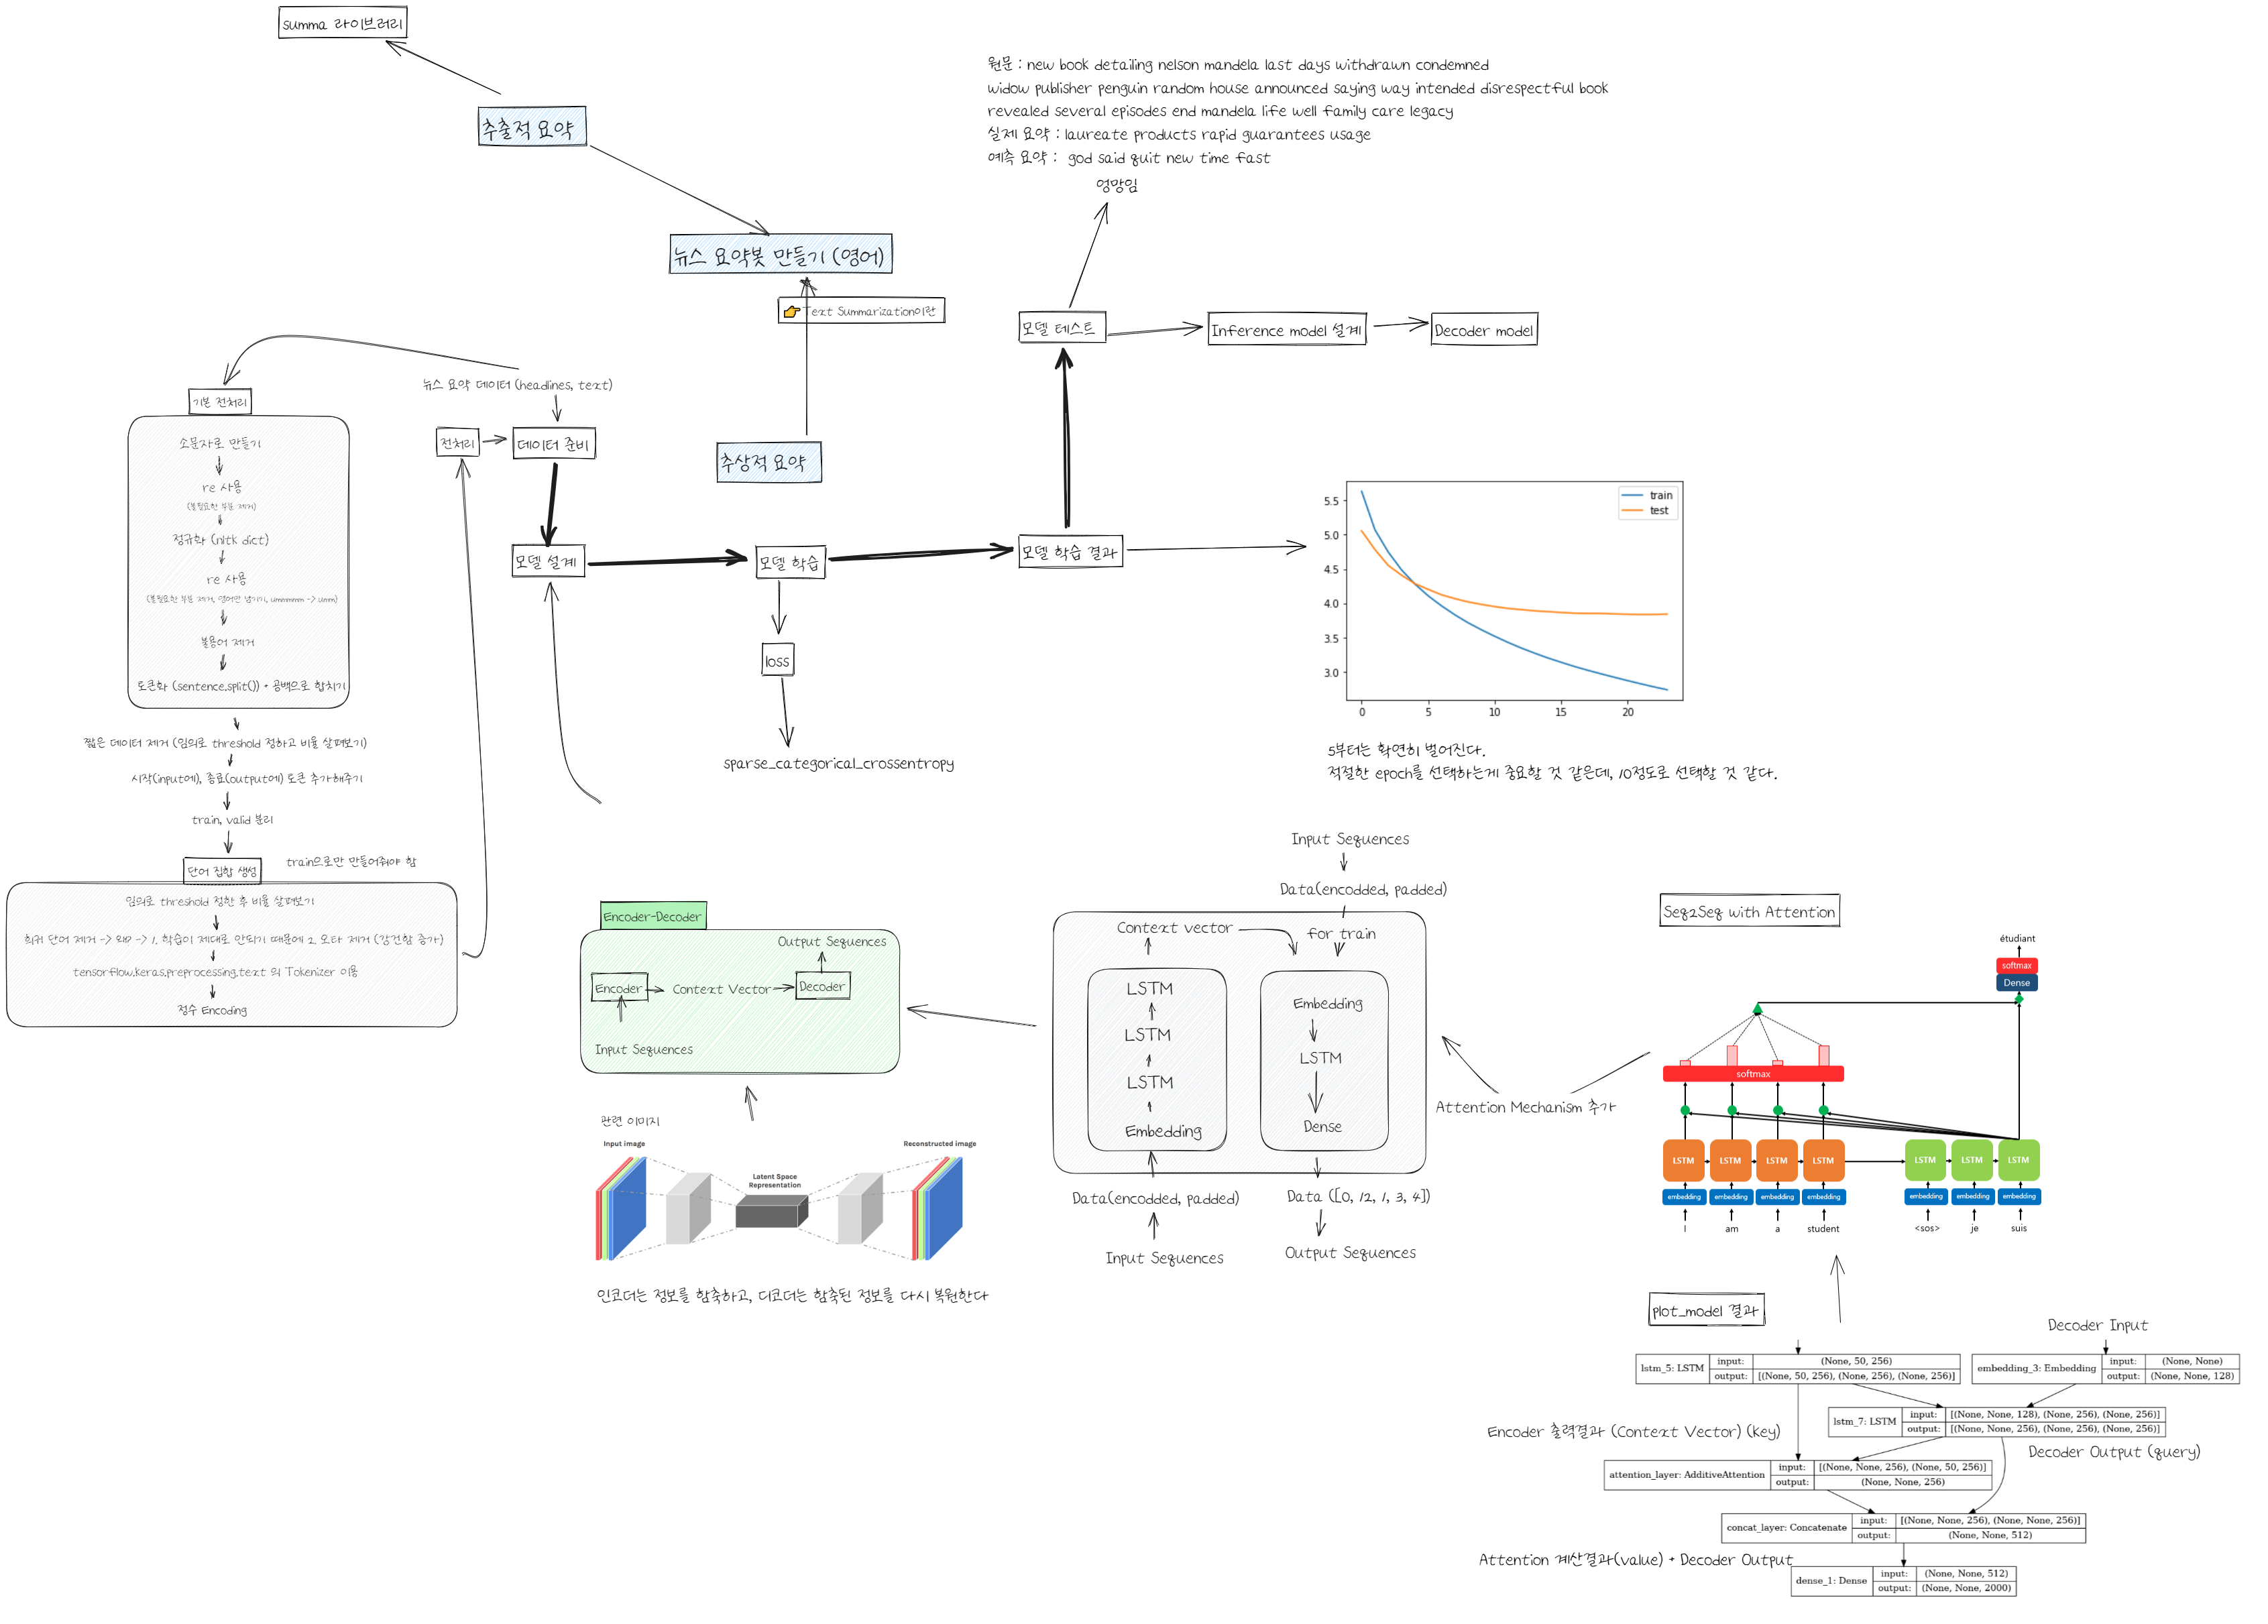

In [64]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

import pandas as pd

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from tqdm import tqdm

print('=3')

3.6.5
2.6.0
1.3.3
1.2.0
=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기

In [65]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

# headline -> 요약된 문장
# text -> 전체 문장

,headlines,text
87489,23 Coptic Christians killed in Egypt terror at...,At least 23 Coptic Christians have reportedly ...
29084,Video: Sikh man wakes up Muslims for morning R...,A video of a Sikh man waking up his Muslim nei...
79262,Chant mantra against China before prayers: RSS,The RSS has asked people to chant a mantra fiv...
17080,Proud to introduce Nutanji's granddaughter Pra...,"Salman Khan, who will be launching actor Mohni..."
5623,"2018 worst year for violence, abuse against jo...",The year 2018 has been the worst for violence ...
73738,Australian batsmen practice facing spin withou...,Australian batsmen faced spin bowling in the n...
20939,Watch: IAF rescues toddler from rooftop in flo...,A video shows a toddler being rescued from a r...
86655,Priyanka's Hollywood debut film Baywatch hits ...,Actress Priyanka Chopra's Hollywood debut film...
15323,Honda recalls 14 lakh cars over airbag issue i...,Honda is recalling 14 lakh US cars which inclu...
13582,World Bank announces $1 billion for quake-hit ...,The World Bank has announced funding of up to ...


# Step 2. 데이터 전처리하기 (추상적 요약)

In [66]:
# 중복 데이터 제거
data.drop_duplicates(subset = ['text'], inplace=True)
# null 제거
data.dropna(axis=0, inplace=True)

In [67]:
# 정규화 사전 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [68]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [69]:
import pickle

In [70]:
# text 전처리하기

# clean_text = []

# for i in tqdm(range(data.shape[0])):
#     result = preprocess_sentence(data['text'].values[i])
#     clean_text.append(result)
    
# print(len(clean_text), data.shape[0])

# # headlines 전처리하기 

# clean_summary = []

# for i in tqdm(range(data.shape[0])):
#     result = preprocess_sentence(data['headlines'].values[i])
#     clean_summary.append(result)
    
# print(len(clean_summary), data.shape[0])

In [71]:
# data['text'] = clean_text
# data['headlines'] = clean_summary

# # 빈 값을 Null 값으로 변환
# data.replace('', np.nan, inplace=True)
# print('=3')
# # null 제거
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

In [72]:
# save
# with open('./data/data.pickle', 'wb') as f:
#     pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# load
with open('./data/data.pickle', 'rb') as f:
    data = pickle.load(f)

In [73]:
# max len 정하기
text_max_len = 45
summary_max_len = 10
# 수작업으로 세주기
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9978344855632371


In [74]:
# 데이터 자르기
data['text'] = data['text'].apply(lambda x: x if len(x.split()) <= text_max_len else np.nan)
data['headlines'] = data['headlines'].apply(lambda x: x if len(x.split()) <= summary_max_len else np.nan)

data = data.dropna()
data = data.reset_index(drop=True)

# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [75]:
# split tr / ts

n_of_val = int(len(encoder_input)  *0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

테스트 데이터의 수 : 19568


In [76]:
# 단어 집합(vocabulary) 만들기

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

# 빈도수 낮은 애들 빼주자
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수

rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

src_vocab = 25957 # 전체 중 3프로 밖에 해당하지 않는 74%의 희귀 단어를 제외했을 때의 단어 집합의 크기
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

단어 집합(vocabulary)의 크기 : 67794
등장 빈도가 4번 이하인 희귀 단어의 수: 41837
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25957
단어 집합에서 희귀 단어의 비율: 61.71195091011003
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.605083117454884
[[23632, 6416, 7017, 8177, 9890, 8749, 1661, 1725, 1988, 1398, 627, 11684, 1736, 2322, 1281, 883, 22, 140, 1225, 1661, 8177, 2543, 605, 349, 961, 5050, 134, 3397, 2315, 1819, 1538, 2175, 8177, 210, 325, 1988, 2193, 62, 8464], [5585, 241, 1272, 1049, 541, 1424, 413, 20353, 600, 101, 2358, 224, 378, 344, 5479, 17, 2, 13625, 8750, 26, 20354, 3683, 2970, 2655, 20353, 4702, 101, 116, 17, 20353, 3512, 124, 2641, 541, 533, 100, 4571, 10577, 3702, 38, 14583, 21806, 11685, 2555], [25, 714, 839, 3, 698, 603, 272, 4651, 72, 224, 8, 88, 89, 88, 272, 144, 3, 261, 119, 88, 813, 239, 5383, 1296, 6572, 1302, 164, 409, 88, 1668, 3, 480, 2497, 2673, 320, 272, 115, 477]]


In [77]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

tar_vocab = 10155
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

단어 집합(vocabulary)의 크기 : 29414
등장 빈도가 5번 이하인 희귀 단어의 수: 19259
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10155
단어 집합에서 희귀 단어의 비율: 65.4756238525872
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.7880464971451735


In [78]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [79]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78274
훈련 레이블의 개수 : 78274
테스트 데이터의 개수 : 19568
테스트 레이블의 개수 : 19568


In [80]:
# Padding 하기

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [81]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len, ))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [83]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [84]:
# 디코더의 출력층
decoder_softmax_layer = Dense(src_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 
 
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 128)      3322496     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 45, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [85]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 128)      3322496     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 45, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

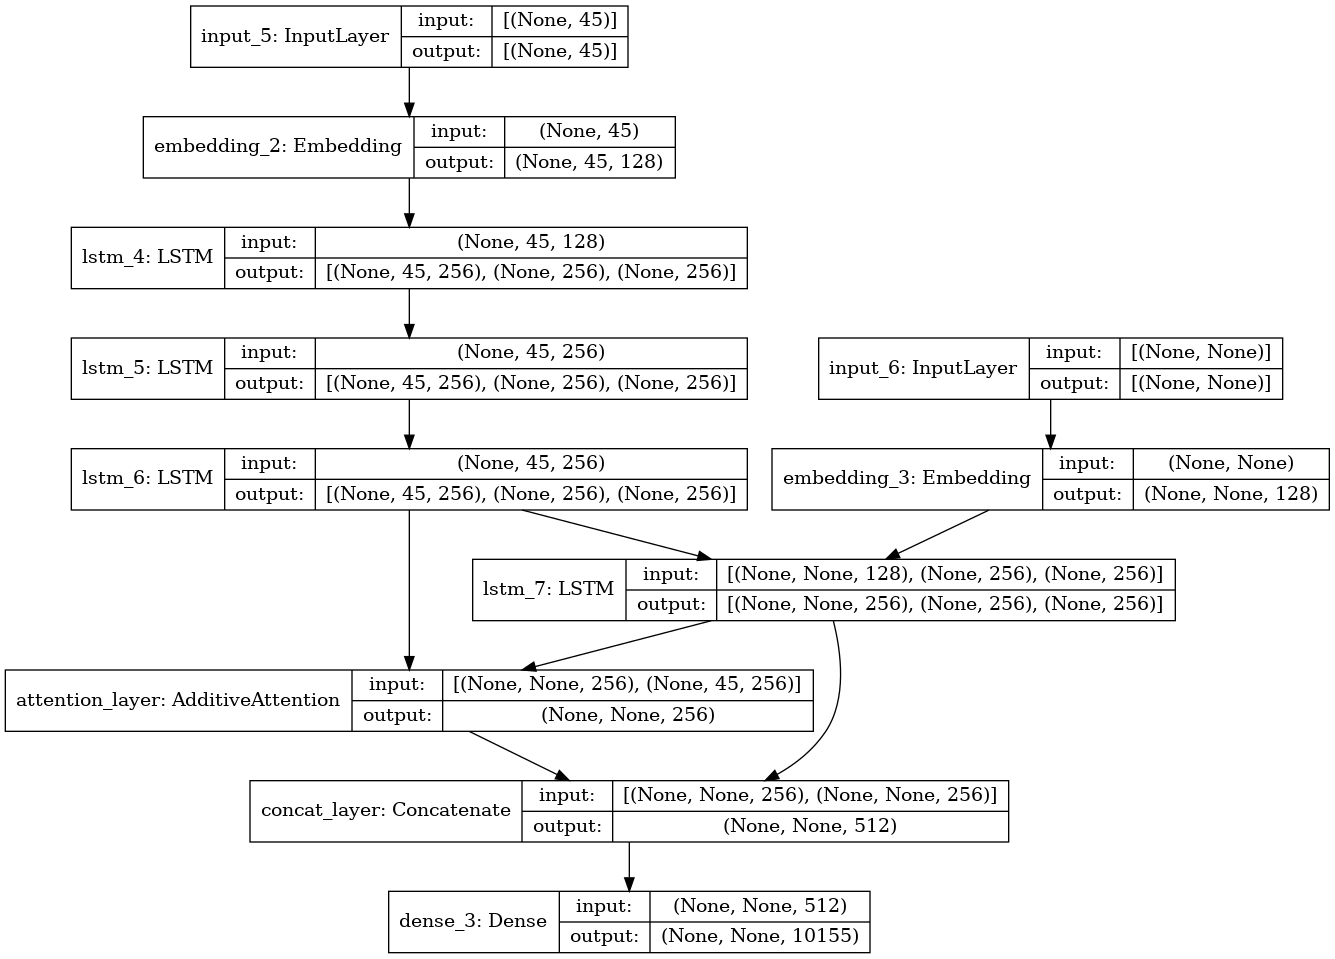

In [86]:
import tensorflow as tf
 
tf.keras.utils.plot_model(model, show_shapes=True)

## 모델 훈련하기

In [87]:
encoder_input_train

array([[23632,  6416,  7017, ...,     0,     0,     0],
       [ 5585,   241,  1272, ..., 11685,  2555,     0],
       [   25,   714,   839, ...,     0,     0,     0],
       ...,
       [ 1564,  3431,  1230, ...,     0,     0,     0],
       [  539,   481,   871, ...,     0,     0,     0],
       [ 1477,   216,  9283, ...,     0,     0,     0]], dtype=int32)

In [88]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 34s 93ms/step - loss: 5.6316 - val_loss: 5.0544
Epoch 2/50
306/306 [==============================] - 28s 92ms/step - loss: 5.0709 - val_loss: 4.7815
Epoch 3/50
306/306 [==============================] - 28s 91ms/step - loss: 4.7463 - val_loss: 4.5511
Epoch 4/50
306/306 [==============================] - 28s 91ms/step - loss: 4.4861 - val_loss: 4.4086
Epoch 5/50
306/306 [==============================] - 28s 91ms/step - loss: 4.2803 - val_loss: 4.2854
Epoch 6/50
306/306 [==============================] - 28s 91ms/step - loss: 4.1084 - val_loss: 4.2019
Epoch 7/50
306/306 [==============================] - 28s 91ms/step - loss: 3.9622 - val_loss: 4.1225
Epoch 8/50
306/306 [==============================] - 28s 91ms/step - loss: 3.8320 - val_loss: 4.0672
Epoch 9/50
306/306 [==============================] - 28s 91ms/step - loss: 3.7150 - val_loss: 4.0185
Epoch 10/50
306/306 [==============================] - 28s 91ms/step - loss: 3.613

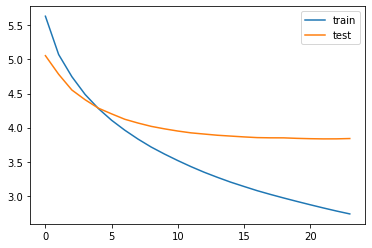

In [89]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [90]:
# inferece 모델 구축

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [91]:
# 모델 테스트하기

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
# 0은 padding에서 사용된 숫자
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
# Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and i != 1 and i != 2):
            temp = temp + src_index_to_word[i]+' '
        
    return temp

print('=3')

=3


In [92]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : brihanmumbai municipal corporation denied ganesh mandal coordination committee demand take approval process setting online committee claimed single window clearance system introduced improve mandal approval rate ineffective reportedly meet mayor vishwanath mahadeshwar demand better clearance system 
실제 요약 : commander want retailer determination fine end bsp 
예측 요약 :  mumbai civic body issues plan illegal defaulters


원문 : year old student harpreet singh happy punjab jalandhar allegedly got girlfriend raped could use excuse avoid marrying according reports two happy friends took abandoned haveli raped day supposed meet parents reports added 
실제 요약 : photo uk accused education student software scheduled 
예측 요약 :  girl raped video girlfriend


원문 : mumbai residents protesting outside brihanmumbai municipal corporation bandra office every monday friday since july complaints resolved months complaints filed bmc public grievance registration system set complaints include illegal encroac

예측 요약 :  never live tv star


원문 : actor neil nitin mukesh took twitter share first look poster upcoming film co stars alongside jackie shroff film also stars kay kay menon karan singh grover dhar film directed bhatt cast expected begin shooting august 
실제 요약 : film business exclusive kilograms taught participated day 
예측 요약 :  first look poster akshay kumar starrer released


원문 : actor mithun chakraborty said advice youngsters concentrate talent compared six pack abs added talent capability crack film industry mithun said one persistent efforts talent cannot anything 
실제 요약 : exit worn cheating stronger authentication qualification 
예측 요약 :  want believe kids become cinema


원문 : actor ayushmann khurrana tweeted please change doordarshan logo represents childhood statement comes recent reports doordarshan planning changing logo create something appeal children doordarshan sporting current logo since inception 
실제 요약 : hailing joshi marshal class villiers 
예측 요약 :  ayushmann khurrana 

예측 요약 :  former former former former ceo joins india


원문 : former ceo infosys kris gopalakrishnan said indian companies need learn manage expectations employees growth rate slows said technology companies must invest employees employees must invest time learning also said automation impacted services like infrastructure management maintenance 
실제 요약 : sri item indians years land modi 
예측 요약 :  india must must work jobs ex ceo


원문 : amrapali ceo kumar sinha director nishant mukul arrested alleged fraud paying labour cess crore labour department amrapali received final recovery notice march failed pay police took action district administration said labour cess charged labour welfare group pay 
실제 요약 : sunrisers modi pakistan gas marking karachi crore 
예측 요약 :  infosys ceo arrested crore fraud




# Step 5. Summa을 이용해서 추출적 요약해보기

In [93]:
import requests
from summa.summarizer import summarize

In [104]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
text

'The screen is filled with green, cascading code which gives way to the title, The Matrix.\r\n\r\nA phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.\r\n\r\nTrinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be \'the One\'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.\r\n\r\nArmed policemen move down a darkened, decrepit hallway in the Heart O\' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick do

In [105]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
